<a href="https://colab.research.google.com/github/zhouchun0105/Fake-News-Detection-Project-BA865/blob/main/ALEX_BA865_Fake_News_Classification_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [1]:
# Importing all necessary libraries and imports

# Basics
import numpy as np
import pandas as pd
from collections import Counter

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout


# sklearn
import sklearn 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split


# NLTK 
import nltk
import re
import string
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


try:
    from scikeras.wrappers import KerasRegressor                     
except ImportError:
    !pip install scikeras
    from scikeras.wrappers import KerasRegressor

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')


  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.11.2
    Uninstalling importlib-metadata-4.11.2:
      Successfully uninstalled importlib-metadata-4.11.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.6 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 3.10.1 which is incompatible.


# Setup and Data Cleaning

In [2]:
# Mounting Google Drive locally
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
# Import data 
df_fakenews_true = pd.read_csv("gdrive/Shared drives/BA865 Group Project/News _dataset/True.csv")
df_fakenews_fake = pd.read_csv("gdrive/Shared drives/BA865 Group Project/News _dataset/Fake.csv")

In [4]:
df_fakenews_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [5]:
df_fakenews_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
df_fakenews_true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [7]:
df_fakenews_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [8]:
print(df_fakenews_true.shape)
print(df_fakenews_fake.shape)

(21417, 4)
(23481, 4)


In [9]:
# checking for any null values
df_fakenews_true.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [10]:
# checking for any null values
df_fakenews_fake.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

# Data Pre-Processing

In [11]:
# creating new colum 'Real/Fake', labeling the two datasets in order to merge and know which observation is real and which one is false
df_fakenews_true['real/fake'] = '1'
df_fakenews_fake['real/fake'] = '0'

In [12]:
# merging the two datasets
frames = [df_fakenews_true, df_fakenews_fake]
news_data_all = pd.concat(frames)
news_data_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      44898 non-null  object
 1   text       44898 non-null  object
 2   subject    44898 non-null  object
 3   date       44898 non-null  object
 4   real/fake  44898 non-null  object
dtypes: object(5)
memory usage: 2.1+ MB


In [14]:
# Removing all links and the headline from the date column
news_data_all = news_data_all[news_data_all.date.str.contains('Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec')]

In [15]:
news_data_all['date'] = pd.to_datetime(news_data_all['date']).dt.date

In [16]:
news_data_all.head()

,title,text,subject,date,real/fake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29,1


In [17]:
news_data_all.describe()

,title,text,subject,date,real/fake
count,44888,44888,44888,44888,44888
unique,38723,38640,8,1010,2
top,Factbox: Trump fills top jobs for his administ...,,politicsNews,2017-12-20,0
freq,14,627,11272,197,23471


In [18]:
# one-hot encoding for subject column
# news_data = pd.get_dummies(news_data_all, columns=["subject"])
news_data = news_data_all

In [19]:
# dropping subject column as subjects across fake and real news articles are unbalanced
news_data = news_data.drop('subject', axis=1)

In [20]:
# title and text can be two seperate variables
news_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44888 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      44888 non-null  object
 1   text       44888 non-null  object
 2   date       44888 non-null  object
 3   real/fake  44888 non-null  object
dtypes: object(4)
memory usage: 1.7+ MB


In [21]:
# merging the title and news text
news_data['content'] = news_data['title']+' '+news_data['text']
news_dataset = news_data[['real/fake', 'date', 'content']]

In [22]:
news_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44888 entries, 0 to 23480
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   real/fake  44888 non-null  object
 1   date       44888 non-null  object
 2   content    44888 non-null  object
dtypes: object(3)
memory usage: 1.4+ MB


In [23]:
# setting random seed
#np.random.seed(865)

In [24]:
# shuffling the cleaned dataset
news_dataset = news_dataset.sample(frac=1).reset_index(drop=True)

shuffled_indices = np.arange(news_dataset.shape[0])
np.random.shuffle(shuffled_indices)

news_dataset = news_dataset.loc[shuffled_indices]

news_dataset.describe(include='all')

,real/fake,date,content
count,44888,44888,44888
unique,2,1010,39099
top,0,2017-12-20,Highlights: The Trump presidency on April 13 a...
freq,23471,197,8


In [25]:
news_dataset.head(10)

,real/fake,date,content
11165,1,2017-12-01,Flynn prepared to testify Trump directed him t...
8567,1,2017-02-15,Tillerson arrives in Bonn amid questions over ...
24500,1,2017-04-02,"Schiff says Trump wants focus on tweets, not R..."
42695,1,2017-11-02,North Korea dismisses report that sixth nuclea...
32459,0,2016-02-09,NEW EMAILS SHOW HILLARY Asking How Meeting On ...
7985,0,2016-05-29,UNREAL! BLACK TRUMP SUPPORTER Threatened And A...
33957,0,2016-09-27,Giuliani Already Trying To Float Excuses For ...
42897,1,2017-11-18,Vatican says investigating alleged abuser who ...
10492,0,2016-02-12,Ohio Cop Suspended After Disgusting Facebook ...
27174,0,2017-03-03,Fox News Posts INCREDIBLY Misleading Tweet De...


# Text Processing

In [26]:
import re
import string

News-Punctuation Cleaning

In [27]:
#Creating a copy 
clean_news=news_dataset.copy()

def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
    


In [28]:
clean_news['content'] = clean_news['content'].apply(lambda x:review_cleaning(x))
clean_news.head()

,real/fake,date,content
11165,1,2017-12-01,flynn prepared to testify trump directed him t...
8567,1,2017-02-15,tillerson arrives in bonn amid questions over ...
24500,1,2017-04-02,schiff says trump wants focus on tweets not ru...
42695,1,2017-11-02,north korea dismisses report that sixth nuclea...
32459,0,2016-02-09,new emails show hillary asking how meeting on ...


News-Stop words

In [29]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [30]:
# removing english stopwords to save space and processing time
stop = stopwords.words('english')
clean_news['content'] = clean_news['content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
clean_news.head()

,real/fake,date,content
11165,1,2017-12-01,flynn prepared testify trump directed contact ...
8567,1,2017-02-15,tillerson arrives bonn amid questions us forei...
24500,1,2017-04-02,schiff says trump wants focus tweets russia pr...
42695,1,2017-11-02,north korea dismisses report sixth nuclear tes...
32459,0,2016-02-09,new emails show hillary asking meeting libyan ...


In [31]:
clean_news['real/fake'] = clean_news['real/fake'].astype(int)

In [32]:
clean_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44888 entries, 11165 to 10161
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   real/fake  44888 non-null  int64 
 1   date       44888 non-null  object
 2   content    44888 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


# EDA

(-0.5, 1299.5, 949.5, -0.5)

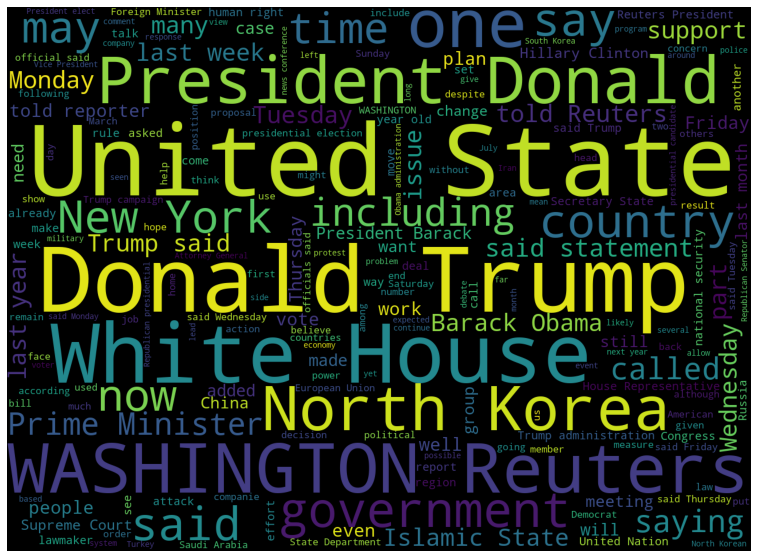

In [33]:
# word cloud for the text real true News
text_true = pd.Series(df_fakenews_true['text'].tolist()).astype(str)

cloud = WordCloud(width=1300, height=950).generate(" ".join(text_true.astype(str)))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off')

(-0.5, 1299.5, 949.5, -0.5)

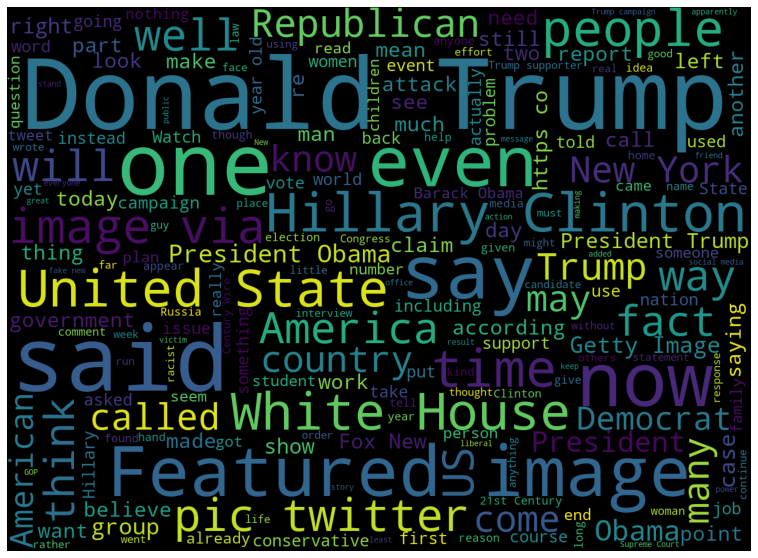

In [34]:
# word cloud for the text false fake News
text_false = pd.Series(df_fakenews_fake['text'].tolist()).astype(str)

cloud = WordCloud(width=1300, height=950).generate(" ".join(text_false.astype(str)))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off')

In [35]:
# subsetting the cleaned, preprocessed news data for real and fake
top_words_real = clean_news[clean_news['real/fake'] == 1]
top_words_fake = clean_news[clean_news['real/fake'] == 0]

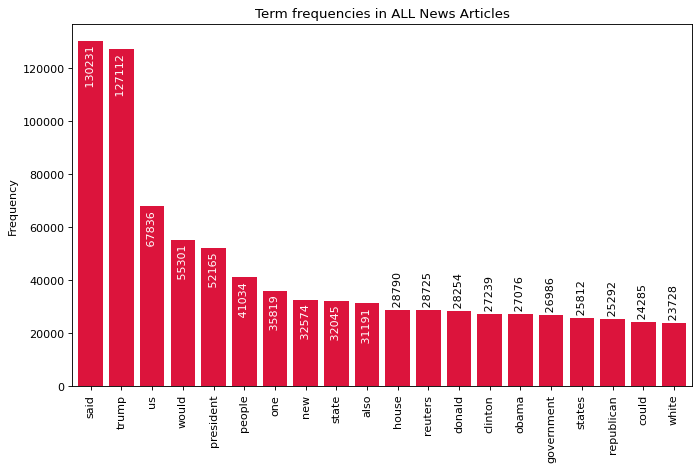

In [36]:
from matplotlib.pyplot import figure

figure(figsize=(10, 6), dpi=80)

tf = Counter(" ".join(clean_news['content']).split())

y = [count for tag, count in tf.most_common(20)]
x = [tag for tag, count in tf.most_common(20)]

plt.bar(x, y, color='crimson')
plt.title("Term frequencies in ALL News Articles")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
for i, (tag, count) in enumerate(tf.most_common(20)):
    plt.text(i, count, f' {count} ', rotation=90,
             ha='center', va='top' if i < 10 else 'bottom', color='white' if i < 10 else 'black')
plt.xlim(-0.6, len(x)-0.4) # optionally set tighter x lims
#plt.tight_layout() # change the whitespace such that all labels fit nicely
plt.show()

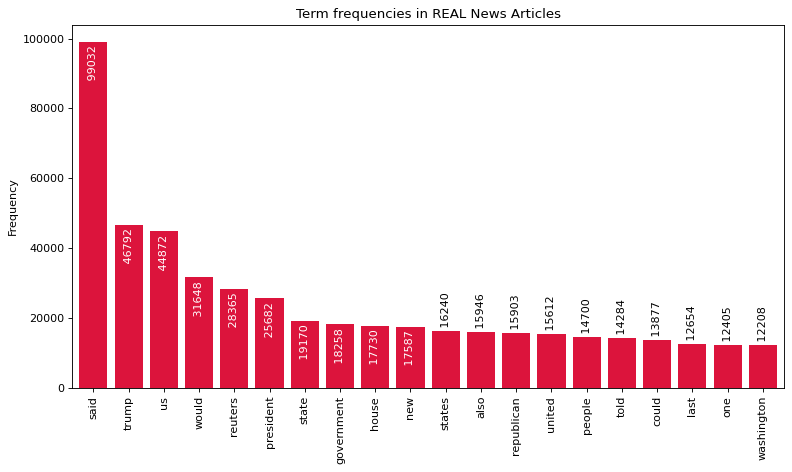

In [37]:
figure(figsize=(10, 6), dpi=80)

tf = Counter(" ".join(top_words_real['content']).split())

y = [count for tag, count in tf.most_common(20)]
x = [tag for tag, count in tf.most_common(20)]

plt.bar(x, y, color='crimson')
plt.title("Term frequencies in REAL News Articles")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
for i, (tag, count) in enumerate(tf.most_common(20)):
    plt.text(i, count, f' {count} ', rotation=90,
             ha='center', va='top' if i < 10 else 'bottom', color='white' if i < 10 else 'black')
plt.xlim(-0.6, len(x)-0.4) # optionally set tighter x lims
plt.tight_layout() # change the whitespace such that all labels fit nicely
plt.show()

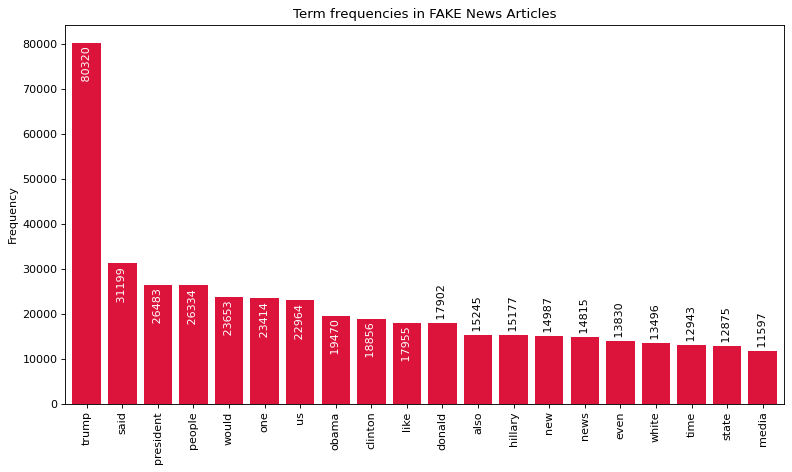

In [38]:
figure(figsize=(10, 6), dpi=80)

tf = Counter(" ".join(top_words_fake['content']).split())

y = [count for tag, count in tf.most_common(20)]
x = [tag for tag, count in tf.most_common(20)]

plt.bar(x, y, color='crimson')
plt.title("Term frequencies in FAKE News Articles")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
for i, (tag, count) in enumerate(tf.most_common(20)):
    plt.text(i, count, f' {count} ', rotation=90,
             ha='center', va='top' if i < 10 else 'bottom', color='white' if i < 10 else 'black')
plt.xlim(-0.6, len(x)-0.4) # optionally set tighter x lims
plt.tight_layout() # change the whitespace such that all labels fit nicely
plt.show()

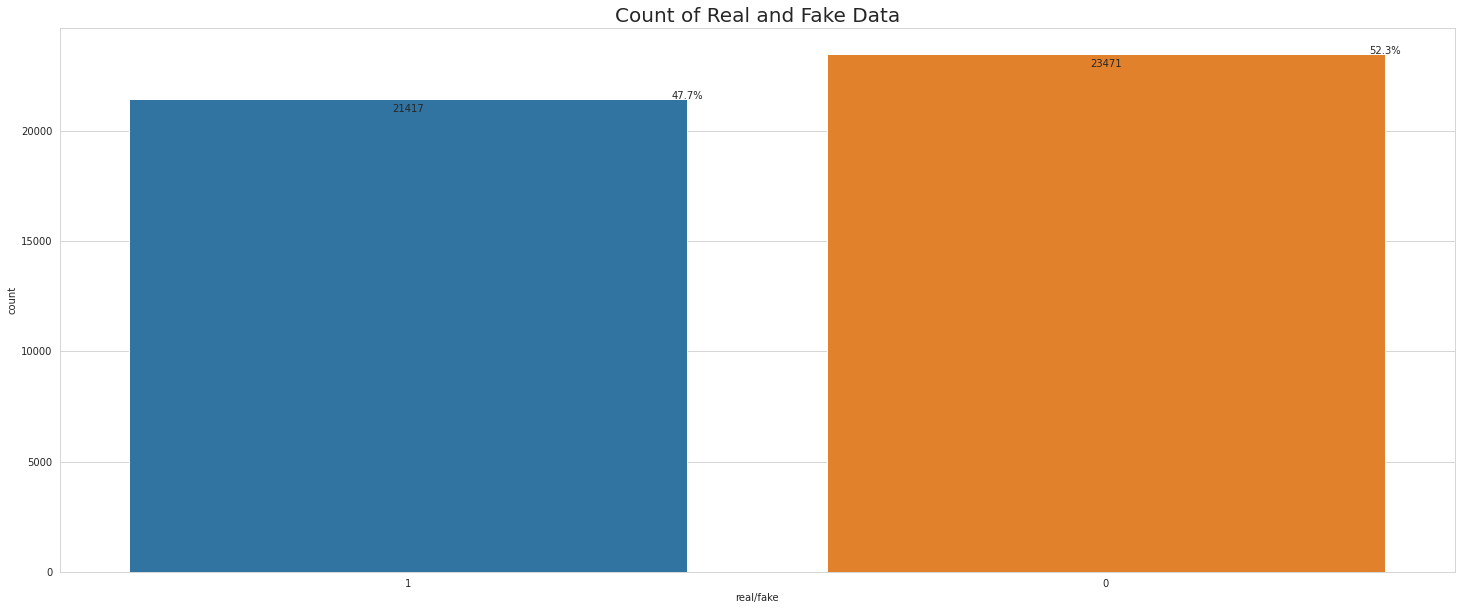

In [39]:
total = float(len(news_data))

sns.set_style('whitegrid')
plt.figure(figsize= (25,10))
fig = sns.countplot(x='real/fake', data= news_data)
plt.title('Count of Real and Fake Data', fontsize=20)
for p in fig.patches:
    fig.annotate(format(int(p.get_height())), 
                   (p.get_x() + p.get_width() / 2, p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=10,
                   xytext = (0, -10), 
                   textcoords = 'offset points')
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    fig.annotate(percentage, (x, y),ha='center')

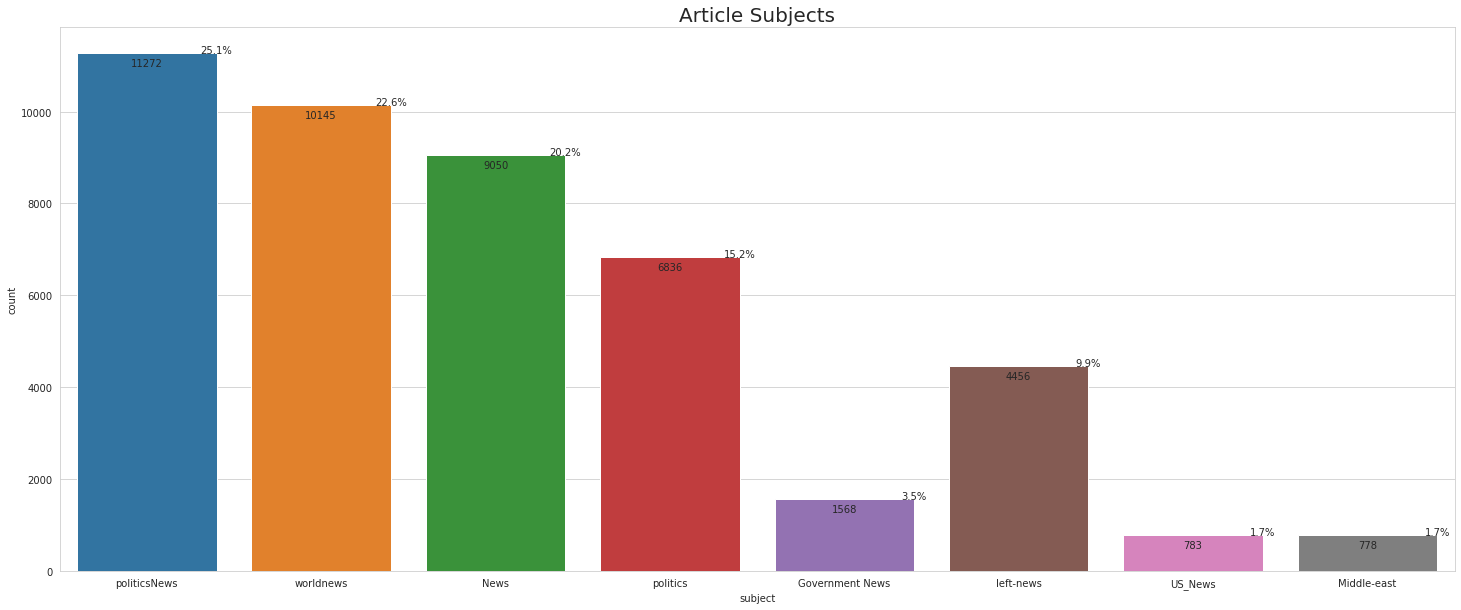

In [40]:
#order=['unknown','Activated','Pending Activation','Inactivated','Non Standard MyChart Status','Patient Declined','Activation Code Generated, but Disabled']
total = float(len(news_data))


plt.figure(figsize= (25,10))
fig = sns.countplot(x='subject', data= news_data_all)
plt.title('Article Subjects', fontsize=20)
for p in fig.patches:
    fig.annotate(format(int(p.get_height())), 
                   (p.get_x() + p.get_width() / 2, p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=10,
                   xytext = (0, -10), 
                   textcoords = 'offset points')
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    fig.annotate(percentage, (x, y),ha='center')


In [41]:
count = news_data_all.groupby(['subject','real/fake']).size().to_frame('count').sort_values(by='count', ascending=False).reset_index()
count

,subject,real/fake,count
0,politicsNews,1,11272
1,worldnews,1,10145
2,News,0,9050
3,politics,0,6836
4,left-news,0,4456
5,Government News,0,1568
6,US_News,0,783
7,Middle-east,0,778


In [42]:
df_fakenews_true.groupby(['subject']).size().to_frame('count').sort_values(by='count', ascending=False).reset_index()

,subject,count
0,politicsNews,11272
1,worldnews,10145


In [43]:
df_fakenews_fake.groupby(['subject']).size().to_frame('count').sort_values(by='count', ascending=False).reset_index()

,subject,count
0,News,9050
1,politics,6841
2,left-news,4459
3,Government News,1570
4,US_News,783
5,Middle-east,778


Time Serires Real/Fake News

In [44]:
# looking at the publication date timespan of all articles
print(news_data_all['date'].min())
print(news_data_all['date'].max())

2015-03-31
2018-02-19


In [45]:
df = news_data.groupby(['real/fake','date']).size().to_frame('count').reset_index()

In [46]:
df.head()

,real/fake,date,count
0,0,2015-03-31,8
1,0,2015-04-01,2
2,0,2015-04-02,1
3,0,2015-04-04,5
4,0,2015-04-05,13


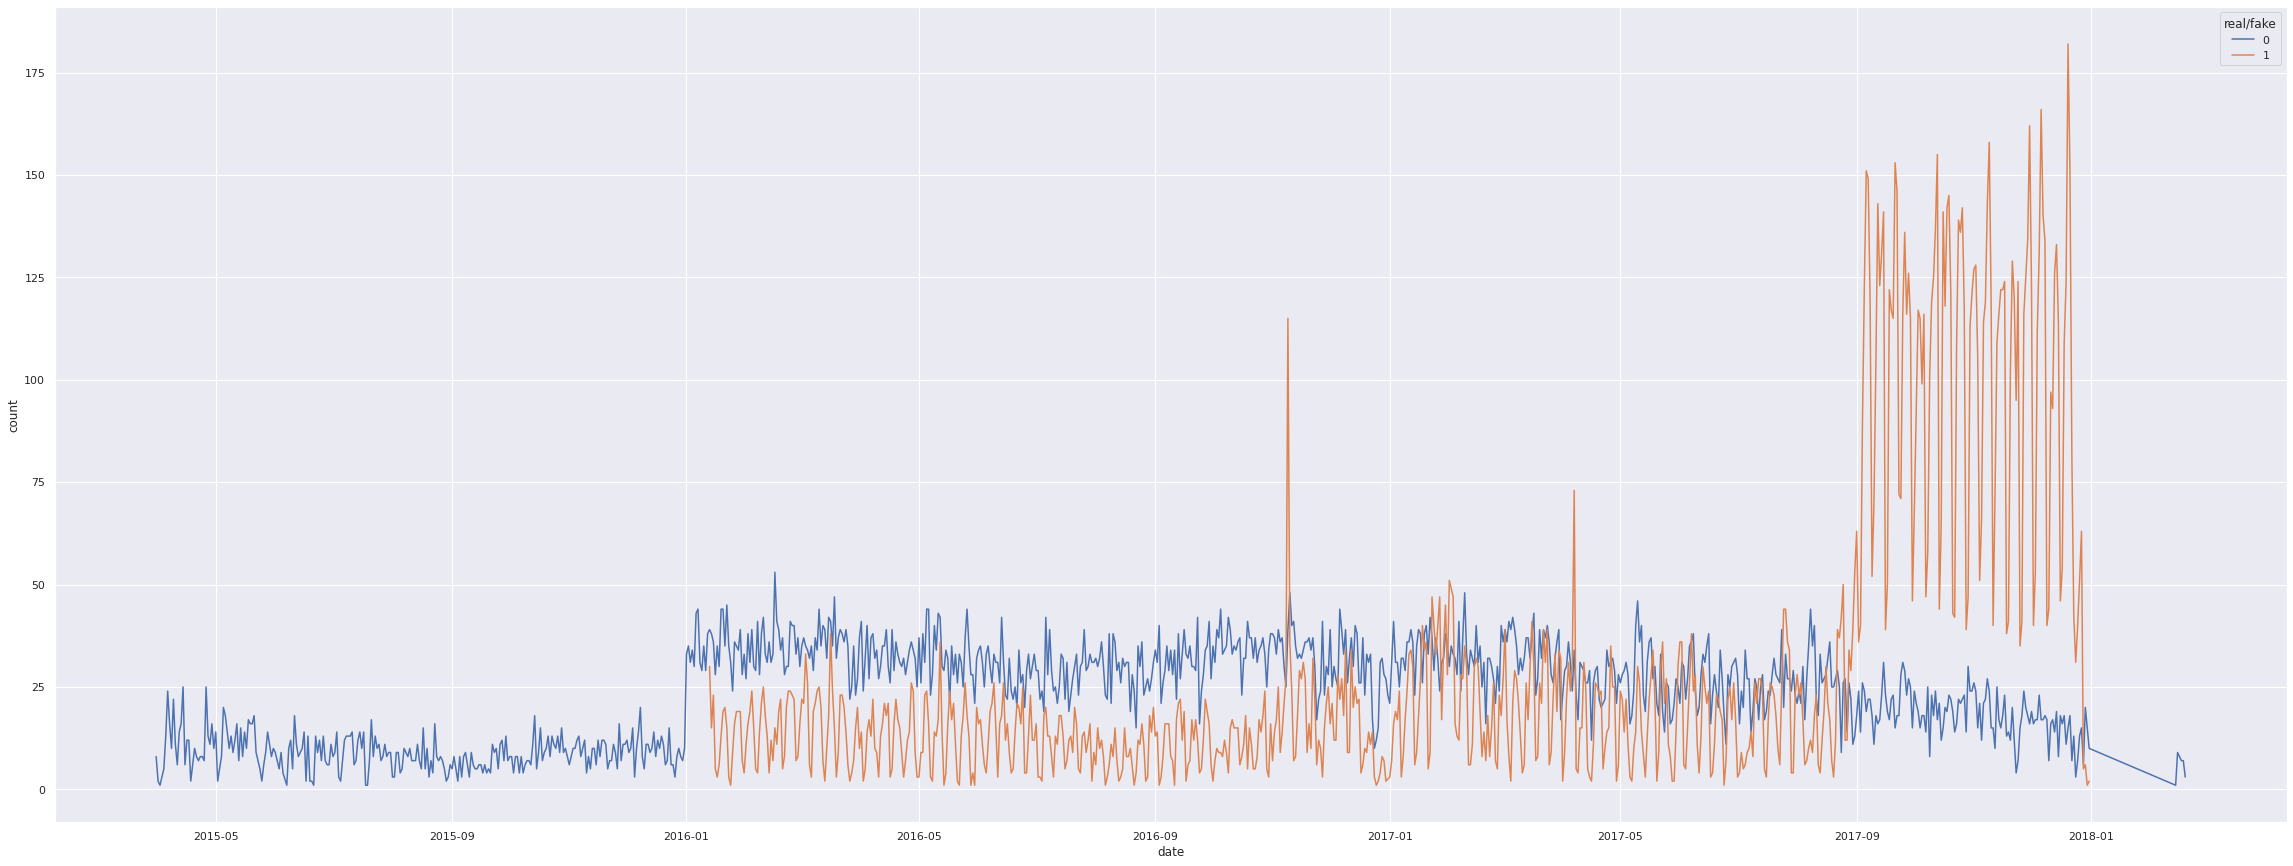

In [47]:
sns.set(rc={'figure.figsize':(40,15)})
sns.lineplot(data=df, x='date', y='count', hue='real/fake')

In [48]:
dispatchers = pd.DataFrame(set(news_data['real/fake']), columns=['real/fake'])
time_index = pd.DataFrame(pd.date_range(start="2015-03-31", end="2018-02-19", freq="D").date,columns=['date'])
skeleton = dispatchers.merge(time_index,how="cross")
skeleton.describe(include='all')

,real/fake,date
count,2114,2114
unique,2,1057
top,0,2015-03-31
freq,1057,2


In [49]:
news_panel = skeleton.merge(news_data,on=['date','real/fake'])
news_panel.describe(include='all')
set(news_panel['real/fake'])

{'0', '1'}

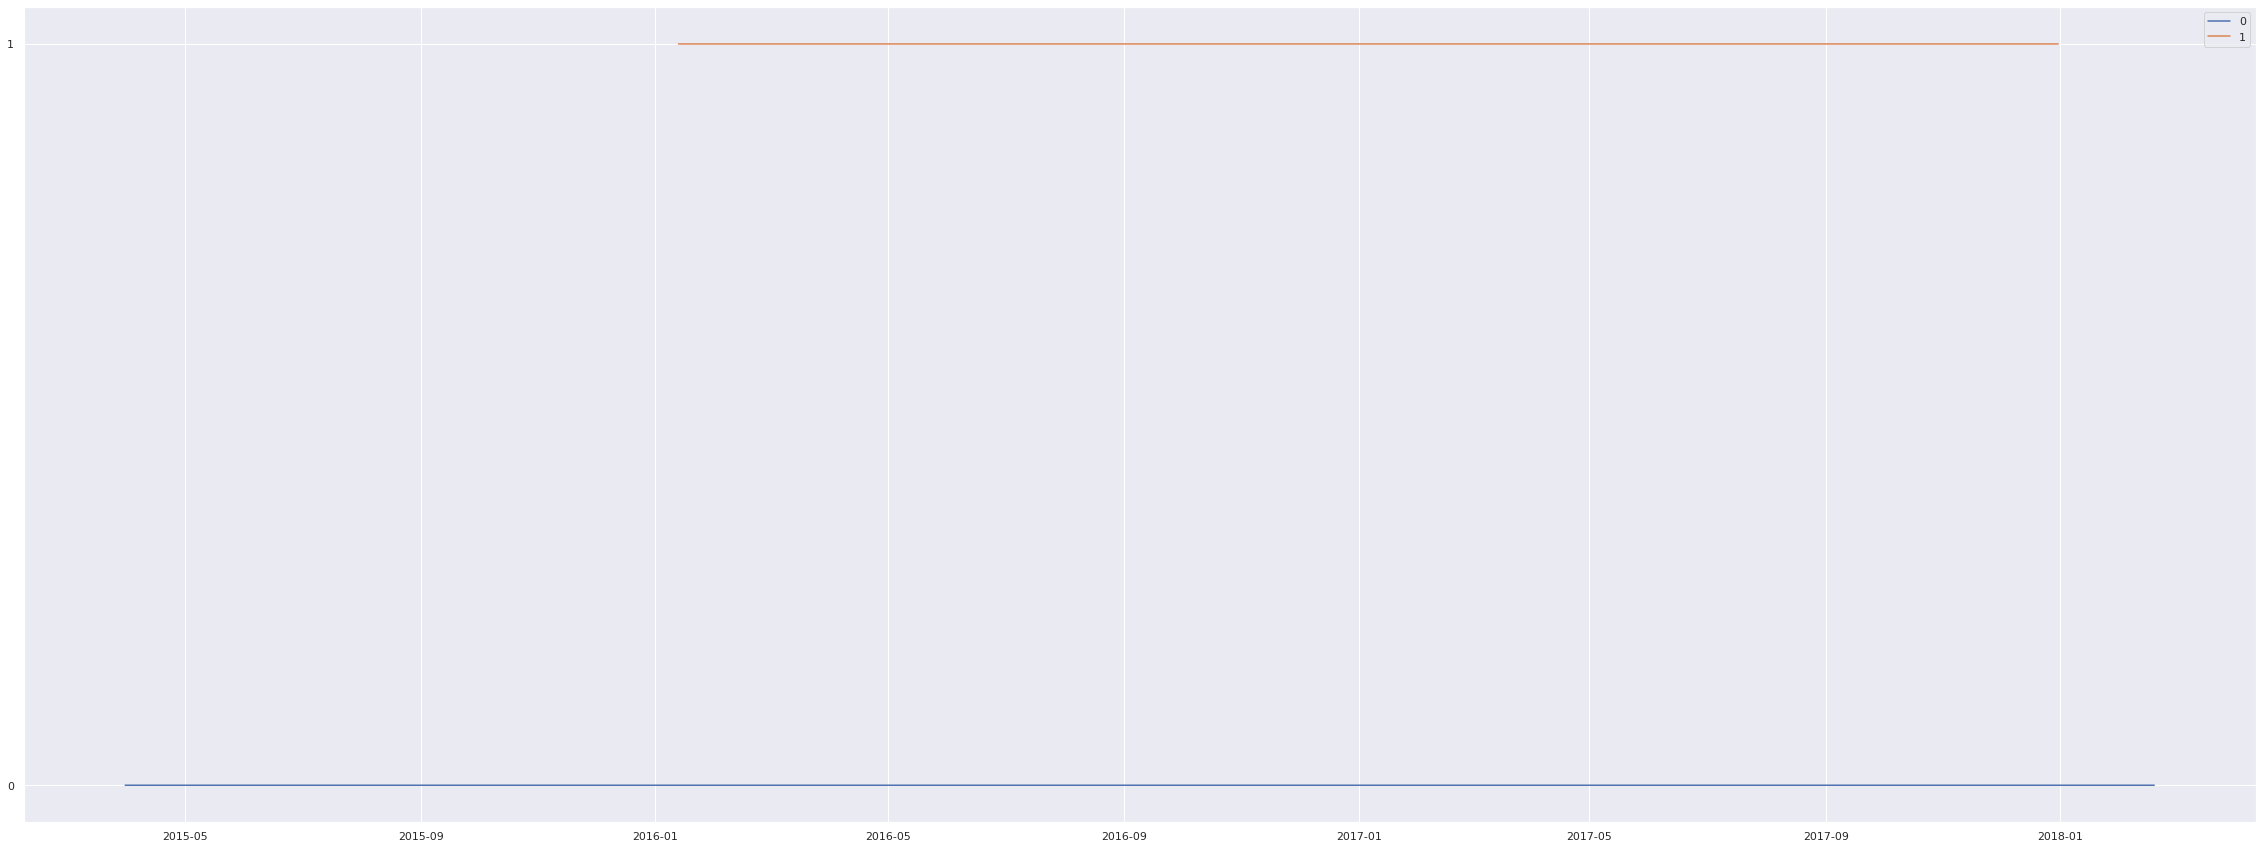

In [50]:
# Let's make one time series for each borough..
for element in set(news_panel['real/fake']):
  plt.plot(news_panel.loc[news_panel['real/fake']==element,'date'],news_panel.loc[news_panel['real/fake']==element,'real/fake'])

plt.legend(list(set(news_panel['real/fake'])))

plt.show()

# Stemming Reviews

Going through a stemming process, which will group together the inflected forms of a word so they can be analyzed as a single item: the stem. 

In [51]:
# Feature extraction 'reviews' for processing
news_features = clean_news.copy()
news_features = news_features[['content']].reset_index(drop=True)
news_features.head()

,content
0,flynn prepared testify trump directed contact ...
1,tillerson arrives bonn amid questions us forei...
2,schiff says trump wants focus tweets russia pr...
3,north korea dismisses report sixth nuclear tes...
4,new emails show hillary asking meeting libyan ...


In [52]:
#Defining Stopwords
stop_words = set(stopwords.words("english"))

#Performing stemming on the review dataframe
ps = PorterStemmer()

#splitting and adding the stemmed words except stopwords
corpus = []
for i in range(0, len(news_features)):
    news = re.sub('[^a-zA-Z]', ' ', news_features['content'][i])
    news= news.lower()
    news = news.split()
    news = [ps.stem(word) for word in news if not word in stop_words]
    news = ' '.join(news)
    corpus.append(news) #Getting the target variable

**CHECK FOR AVERAGE LENGTH OF EACH TEXT 6.5, not sure if this is right**

Before we proceed, do we expect a Sequence model to be helpful here (versus a bag of words model)? Recall, we should check the ratio of observations in training to mean number of tokens per sample. We don't expect to get much value at all from a sequential text model in this case, because we would need a much bigger dataset (on the order of 2.5 million observations).

In [53]:
lengths = [len(x) for x in corpus]

print(f'The average article in our data has {np.mean(lengths)} words, and we have {len(clean_news)} samples.')
print(f'The ratio of samples to average sample length is thus {len(clean_news)/np.mean(lengths)}. We are nowhere close to 1500.')

The average article in our data has 1554.6395250401 words, and we have 44888 samples.
The ratio of samples to average sample length is thus 28.873574405515114. We are nowhere close to 1500.


One-Hot encoding for the embedding layers

In [ ]:
#Setting up vocabulary size
voc_size = 12000

#One hot encoding 
onehot_repr = [one_hot(words,voc_size)for words in corpus]

Padding embedded docs

In [ ]:
#Setting sentence length
sent_length = 6000

#Padding the sentences
embedded_docs = pad_sequences(onehot_repr,padding = 'pre',maxlen = sent_length)
print(embedded_docs)

[[    0     0     0 ... 11943  6016 11690]
 [    0     0     0 ... 11943  1468 10952]
 [    0     0     0 ...  3776  5267  5440]
 ...
 [    0     0     0 ...  3053  1468 10952]
 [    0     0     0 ...  1098  3343  4202]
 [    0     0     0 ... 11943  1468 10952]]


# Model with one input and CV (TITLE AND TEXT COMBINDED)

LSTM Model

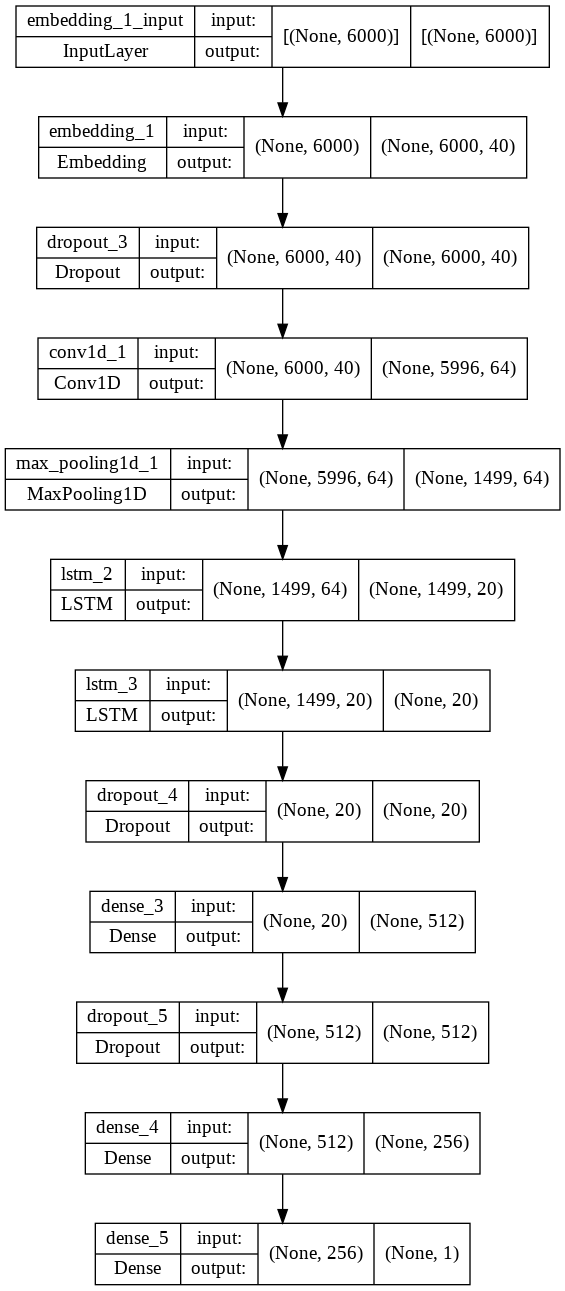

In [ ]:
# building a model
def build_model():

    embedding_vector_features=40

    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(voc_size,embedding_vector_features,input_length=sent_length),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Conv1D(64, 5, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=4),
        tf.keras.layers.LSTM(20, return_sequences=True),
        tf.keras.layers.LSTM(20),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

    return model

model = build_model()
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# Displaying the model Summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 6000, 40)          480000    
                                                                 
 dropout_3 (Dropout)         (None, 6000, 40)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 5996, 64)          12864     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1499, 64)         0         
 1D)                                                             
                                                                 
 lstm_2 (LSTM)               (None, 1499, 20)          6800      
                                                                 
 lstm_3 (LSTM)               (None, 20)                3280      
                                                      

Fitting the Model

In [ ]:
# Defining the label column
label = clean_news['real/fake']

# Converting the X and y as array
text = np.asarray(embedded_docs).astype("float32")
label = np.asarray(label).astype("float32")

# Checking shape of X and y
text.shape,label.shape

((44888, 6000), (44888,))

In [ ]:
# Checking how much of the data to take out for the testing dataset (validation)
val_split = int(len(label)*0.33)

In [ ]:
# defining train and test data
data_train = text[:val_split]
labels_train = label[:val_split]
data_test = text[val_split:]
labels_test = label[val_split:]

In [ ]:
k = 2
num_validation_samples = len(data_train) // k
num_epochs = 4
batch_sizes = 100
all_loss_histories = []
all_val_loss_histories = []  
all_acc_histories = []
all_val_acc_histories = []

# For each validation fold, we will train a full set of epochs, and store the history. 
for fold in range(k):
    validation_data = data_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    validation_targets = labels_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    training_data = np.concatenate([
        data_train[:num_validation_samples * fold],
        data_train[num_validation_samples * (fold + 1):]])
    training_targets = np.concatenate([
        labels_train[:num_validation_samples * fold],
        labels_train[num_validation_samples * (fold + 1):]])
    model = build_model()
    history = model.fit(training_data, training_targets, 
                        validation_data = (validation_data,validation_targets), 
                        epochs=num_epochs, batch_size=batch_sizes)
    val_loss_history = history.history['val_loss']
    val_acc_history = history.history['val_accuracy']
    loss_history = history.history['loss']
    acc_history = history.history['accuracy']
    all_val_loss_histories.append(val_loss_history)
    all_loss_histories.append(loss_history)
    all_val_acc_histories.append(val_acc_history)
    all_acc_histories.append(acc_history)

average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
average_val_acc_history = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]

Epoch 1/4
75/75 [==============================] - 317s 4s/step - loss: 0.4955 - accuracy: 0.7348 - val_loss: 0.1740 - val_accuracy: 0.9446
Epoch 2/4
75/75 [==============================] - 345s 5s/step - loss: 0.1082 - accuracy: 0.9661 - val_loss: 0.0898 - val_accuracy: 0.9714
Epoch 3/4
75/75 [==============================] - 298s 4s/step - loss: 0.0299 - accuracy: 0.9934 - val_loss: 0.0857 - val_accuracy: 0.9762
Epoch 4/4
75/75 [==============================] - 301s 4s/step - loss: 0.0291 - accuracy: 0.9919 - val_loss: 0.1350 - val_accuracy: 0.9662
Epoch 1/4
75/75 [==============================] - 305s 4s/step - loss: 0.4016 - accuracy: 0.7762 - val_loss: 0.1307 - val_accuracy: 0.9557
Epoch 2/4
75/75 [==============================] - 301s 4s/step - loss: 0.0875 - accuracy: 0.9743 - val_loss: 0.0739 - val_accuracy: 0.9777
Epoch 3/4
75/75 [==============================] - 295s 4s/step - loss: 0.0249 - accuracy: 0.9932 - val_loss: 0.0877 - val_accuracy: 0.9731
Epoch 4/4
75/75 [===

Plotting Model Performance and evaluating against Test Set

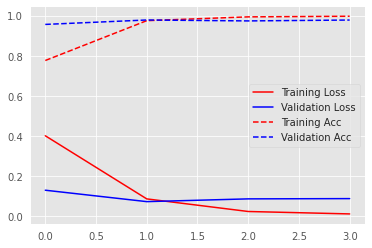

940/940 [==============================] - 291s 309ms/step - loss: 0.0868 - accuracy: 0.9769
Test acc: 0.977


In [ ]:
plt.style.use('ggplot')

plt.plot(history.history['loss'],c="r")
plt.plot(history.history['val_loss'],c="b")
plt.plot(history.history['accuracy'],c="r",linestyle="--")
plt.plot(history.history['val_accuracy'],c="b",linestyle="--")
plt.legend(['Training Loss','Validation Loss','Training Acc','Validation Acc'])
plt.show()

print(f"Test acc: {model.evaluate(data_test,labels_test)[1]:.3f}")

Evaluation of the model

In [ ]:
# Train test split of the X and y final
X_train, X_test, y_train, y_test = train_test_split(text, label, test_size=0.33, random_state=865, shuffle=True)

In [ ]:
history = model.fit(X_train, y_train, epochs=4, batch_size=100, validation_data=(X_test, y_test))

Epoch 1/4
301/301 [==============================] - 1352s 4s/step - loss: 0.1822 - accuracy: 0.9107 - val_loss: 0.0348 - val_accuracy: 0.9910
Epoch 2/4
301/301 [==============================] - 1244s 4s/step - loss: 0.1097 - accuracy: 0.9675 - val_loss: 0.0340 - val_accuracy: 0.9932
Epoch 3/4
301/301 [==============================] - 1304s 4s/step - loss: 0.0788 - accuracy: 0.9792 - val_loss: 0.0703 - val_accuracy: 0.9796
Epoch 4/4
301/301 [==============================] - 1238s 4s/step - loss: 0.0277 - accuracy: 0.9938 - val_loss: 0.0314 - val_accuracy: 0.9932


# Multi Input Model with CV 

In [ ]:
# Defining the label column
y = clean_news['real/fake']

# Converting the X and y as array
X = np.asarray(embedded_docs).astype("float32")
y = np.asarray(y).astype("float32")

# Checking shape of X and y
X.shape,y.shape

((44888, 6000), (44888,))

In [ ]:
# Train test split of the X and y final
X_train, X_test, y_train, y_test = train_test_split(text, label, test_size=0.33, random_state=865, shuffle=True)

In [ ]:
# building a model
def build_model():

    embedding_vector_features=40

    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(voc_size,embedding_vector_features,input_length=sent_length),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Conv1D(64, 5, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=4),
        tf.keras.layers.LSTM(20, return_sequences=True),
        tf.keras.layers.LSTM(20),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

    return model

model = build_model()
keras.utils.plot_model(model, show_shapes=True)

AttributeError: ignored

In [ ]:
# Displaying the model Summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 6000, 40)          480000    
                                                                 
 dropout_7 (Dropout)         (None, 6000, 40)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 5996, 64)          12864     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 1499, 64)         0         
 1D)                                                             
                                                                 
 lstm_5 (LSTM)               (None, 1499, 20)          6800      
                                                                 
 lstm_6 (LSTM)               (None, 20)                3280      
                                                      

In [ ]:
history = model.fit(X_train, y_train, epochs=15, batch_size=66, validation_data=(X_test, y_test))

Epoch 1/15
456/456 [==============================] - 1360s 3s/step - loss: 0.1652 - accuracy: 0.9303 - val_loss: 0.0945 - val_accuracy: 0.9694
Epoch 2/15
456/456 [==============================] - 1376s 3s/step - loss: 0.0295 - accuracy: 0.9936 - val_loss: 0.0251 - val_accuracy: 0.9931
Epoch 3/15
456/456 [==============================] - 1368s 3s/step - loss: 0.0121 - accuracy: 0.9973 - val_loss: 0.0167 - val_accuracy: 0.9961
Epoch 4/15
 98/456 [=====>........................] - ETA: 16:20 - loss: 0.0122 - accuracy: 0.9969

KeyboardInterrupt: ignored

Evaluation of the moodel

In [ ]:
# Predicting from test data
y_pred=model.predict_classes(X_test)

#Creating confusion matrix
#confusion_matrix(y_test,y_pred)
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,classes=['Fake','True'])

In [ ]:
#Checking for accuracy
accuracy_score(y_test,y_pred)

In [ ]:
# Creating classification report 
print(classification_report(y_test,y_pred))

ltsm
bi directional lstm
GloVe
